# Initial setups

In [1]:
using JuMP
using Gurobi
env = Gurobi.Env()

using Plots

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


# Simple 3-bus case

## case
In that case, Bus 1 and bus 2 are in the same substation. Line 1-2 is the internal connection: if it (its switch) is open, there are 2 nodes else only 1.

![myimage.png](./simple%203%20bus%20case.svg)

## Model

cost to minimize = $\sum{ls_i} - \alpha * sw$ (load shedding bus $i$: $ls_i$. switch state : $sw=1$ if closed, $sw=0$ if open)

$|\theta_2 - \theta_1| \le (1-sw) \times M$ (not used in the implementation)

### case $sw = 0 \implies \theta_1 \neq \theta_2$

$ P_{0i} = b_{0i} \theta_i = P_i^* = P_i - ls_i \le \overline{P_{0i}} \implies P_i - ls_i - sw.M \le \overline{P_{0i}}$

$ 0 \le ls_i \le P_i $

### case $sw = 1 \implies \theta_1 = \theta_2 = \theta $

$ \theta = \frac{P_{01}^* + P_{02}^*}{b_{01} + b_{02}}$ 

$ b_{0i}\theta_i \leq \overline{P_{0i}} \implies b_{0i} . \frac{P_1 + P_2 - ls_1 - ls_2}{b_{01} + b_{02}} - (1-sw)M \leq \overline{P_{0i}} $



### boundary lines -> plotting
if $sw=0$, the boundary line is  $P_{0i} = \overline{P_{0i}}$

if $sw=1$, then 

$$
\begin{pmatrix} P_{01} \\ P_{02} \\ P_{12} \end{pmatrix}
= \frac{1}{b_{01} + b_{02}}
	\begin{pmatrix}
		b_{01} & b_{01} \\ b_{02} & b_{02} \\ -b_{02} & b_{01}
	\end{pmatrix}
	\begin{pmatrix}P_1 \\ P_2\end{pmatrix}
$$

Therefore $P_{0i} = \frac{b_{0i}}{b_{01} + b_{02}} * P_i$ and the boundary line for connected operation is:
$ P_1 + P_2 = \min({\frac{b_{01} + b_{02}}{b_{0i}}\overline{P_{0i}}})  $

In [2]:
function plot_results_frame(P01M, P02M, b01, b02)
    coef = 2
    nb = 20
    scale(i) = coef * i / nb
    i = range(0, nb)
    vec_range = scale.(i)
    p = plot([0, coef * P01M], [P02M, P02M], lc = :red, legend = false)
    plot!([P01M, P01M], [0, coef * P02M], lc = :red)
    plot!([0, P01M * coef], min((1+b02/b01) * P01M, (1+b01/b02) * P02M) .- [0, coef * P01M], lc = :blue)
    xlabel!("P1")
    ylabel!("P2")
    xlims!(0, P01M*coef)
    ylims!(0, P02M*coef)
end

function plot_results(p, P1, P2, ls1, ls2, sw, show_orig::Bool= false, show_target::Bool= false)
    if show_orig
        ls = ls1 + ls2
        scatter!(p, [P1],[P2], msw=0, mc = sw==0 ? :red : :blue, markershape = ls==0 ? :xcross : :circle,
            markersize = ls==0 ? 3 : (7 * ls))
    end
    if show_target
        scatter!(p, [P1 - ls1], [P2 - ls2], mc= sw==0 ? :red : :green, markershape = :xcross, markersize = 1)
    end
end

function single_result(model_builder, P01M, P02M, b01, b02, P1, P2, verbose = false)
    model = model_builder(P01M, P02M, b01, b02, P1, P2)
    optimize!(model)
    if verbose
        print(model)
        print(solution_summary(model))
        print("\nls1: $(value(model[:ls1])), ls2: $(value(model[:ls2])), sw:$(value(model[:sw]))")
    end
    p = plot_results_frame(P01M, P02M,b01, b02)
    plot_results(p, P1, P2, value(model[:ls1]), value(model[:ls2]), value(model[:sw]), true, true)
end

function build_grid_results(model_builder, P01M, P02M, b01, b02, nb, coef)
    result = Array{NTuple{5, Float64}, 2}(undef, nb+1, nb+1)
    for i in 1 : nb + 1
        for j in 1 : nb + 1
            P1 = coef * P01M * (i-1) / nb
            P2 = coef * P02M * (j-1) / nb
            m = model_builder(P01M, P02M, b01, b02, P1, P2)
            optimize!(m)
            result[i,j] = (P1, P2, value(m[:ls1]), value(m[:ls2]),  value(m[:sw]))
        end
    end
    result
end

function plot_grid_results(P01M, P02M, b01, b02, result)
    p = plot_results_frame(P01M, P02M, b01, b02)
    for (i, (P1, P2, ls1, ls2, sw)) in enumerate(result)
        plot_results(p, P1, P2, ls1, ls2, sw, true, false)
    end
    display(p)
end

plot_grid_results (generic function with 1 method)

## Model

In [3]:
function build_model(P01M, P02M, b01, b02, P1, P2)
    bM = 1e3

    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    @variable(model, 0 ≤ ls1 ≤ P1)
    @variable(model, 0 ≤ ls2 ≤ P2)
    @variable(model, sw, Bin)

    constr_sw_open(p, ls, sw, p_max) =
        @constraint(model, p - ls - sw * bM ≤p_max)
    
    constr_sw_close(p1, p2, ls1, ls2, b1, b2, sw, p_max) =
        @constraint(model, b1 / (b1 + b2) * (p1 + p2 - ls1 - ls2) - (1 - sw) * bM ≤ p_max)
    
    constr_sw_open(P1, ls1, sw, P01M)
    constr_sw_open(P2, ls2, sw, P02M)
    constr_sw_close(P1, P2, ls1, ls2, b01, b02, sw, P01M)
    constr_sw_close(P1, P2, ls1, ls2, b02, b01, sw, P02M)
    @objective(model, Min, ls1 + ls2 - sw / 1000)

    return model
end


build_model (generic function with 1 method)

In [4]:
b01, b02 = 1.25, 1
P1, P2 = 1.5, 1.4
P01M, P02M = 1.5, 1
bM = 1e3
model = build_model(P01M, P02M, b01, b02, P1, P2)
optimize!(model)
print(solution_summary(model))
print("\nls1: $(value(model[:ls1])), ls2: $(value(model[:ls2])), sw:$(value(model[:sw]))")
latex_formulation(model)

* Solver : Gurobi

* Status
  Result count       : 2
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 4.00000e-01
  Objective bound    : 4.00000e-01
  Relative gap       : 0.00000e+00
  Dual objective value : 4.00000e-01

* Work counters
  Solve time (sec)   : 7.33304e-03
  Barrier iterations : 0
  Node count         : 0

ls1: 0.0, ls2: 0.3999999999999999, sw:0.0

$$ \begin{aligned}
\min\quad & ls1 + ls2 - 0.001 sw\\
\text{Subject to} \quad & -ls1 - 1000 sw \leq 0\\
 & -ls2 - 1000 sw \leq -0.3999999999999999\\
 & -0.5555555555555556 ls1 - 0.5555555555555556 ls2 + 1000 sw \leq 999.8888888888889\\
 & -0.4444444444444444 ls1 - 0.4444444444444444 ls2 + 1000 sw \leq 999.7111111111111\\
 & ls1 \geq 0\\
 & ls2 \geq 0\\
 & ls1 \leq 1.5\\
 & ls2 \leq 1.4\\
 & sw \in \{0, 1\}\\
\end{aligned} $$

## Results

### Single result

Min ls1 + ls2 - 0.001 sw
Subject to
 -ls1 - 1000 sw ≤ 0
 -ls2 - 1000 sw ≤ -0.3999999999999999
 -0.5555555555555556 ls1 - 0.5555555555555556 ls2 + 1000 sw ≤ 999.8888888888889
 -0.4444444444444444 ls1 - 0.4444444444444444 ls2 + 1000 sw ≤ 999.7111111111111
 ls1 ≥ 0
 ls2 ≥ 0
 ls1 ≤ 1.5
 ls2 ≤ 1.4
 sw binary
* Solver : Gurobi

* Status
  Result count       : 2
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 4.00000e-01
  Objective bound    : 4.00000e-01
  Relative gap       : 0.00000e+00
  Dual objective value : 4.00000e-01

* Work counters
  Solve time (sec)   : 3.35932e-04
  Barrier iterations : 0
  Node count         : 0

ls1: 0.0, ls2: 0.3999999999999999, sw:0.0

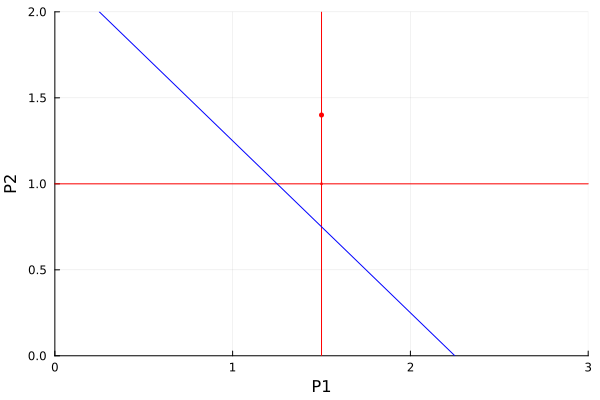

In [5]:
single_result(build_model, 1.5, 1, 1.25, 1, 1.5, 1.4, true)

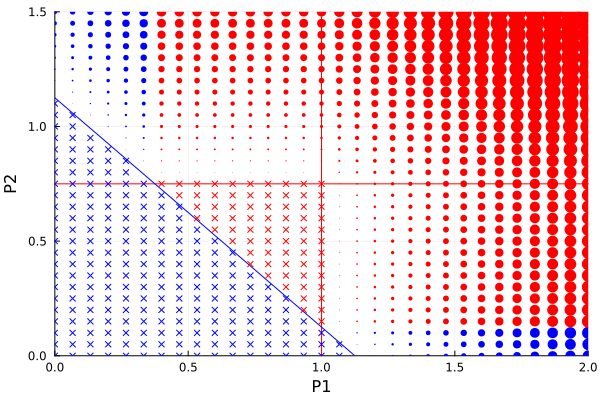

In [6]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
nb, coef = 30, 2

result = build_grid_results(build_model, P01M, P02M, b01, b02, nb, coef)
plot_grid_results(P01M, P02M, b01, b02, result)

## Bus splitting

## case
In that case, Bus 1 and bus 2 are in the same substation. Line 1-2 is the internal connection: if it (its switch) is open, there are 2 nodes else only 1.

![myimage.png](./simple%203%20bus%20case%20NB.svg)

## Model

### $sw = 1 \implies idem $ previous case

## $sw = 0$
### Constraints on flows

$P_{0i} \le \overline{P_{01}} \implies sw_i . P_1 + (1-sw_i)P_2 - sw . M \le \overline{P_{0i}}$

$sw_i = 0 \implies P_2 - sw.M \le \overline{P_{0i}} \implies P2 - sw.M - sw_i.M \le \overline{P_{0i}}$

$sw_i = 1 \implies P1 - sw.M \le \overline{P_{0i}} \implies P1 - sw.M - (1-sw_i).M \le \overline{P_{0i}}$

### constraint on connectivity

$sw_1 + sw_2 = 1 \implies sw_1 + sw_2 \le 1 + sw_0 \ and \ sw_1 + sw_2 \ge 1 - sw_0 $

Note: it also ensures that the lines are connected to 2 different buses even if $sw=1$ - which is good anyway. If we don't want that effect, then multiply $sw_0$ by $M$ in the connectivity constraint.

In [7]:
function build_model_bus_splitting(P01M, P02M, b01, b02, P1, P2)
    bM = 1e3
    
    p_list = Dict(1 => P1, 2 => P2)

    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)
    
    bus_set = 1:2
    b = b01, b02
    P = P1, P2
    PM = P01M, P02M
    
    @variable(model, ls[i in bus_set] ≥ 0)
    @variable(model, sw, binary=true)
    @variable(model, swi[i in bus_set], binary=true)
    
    @constraint(model, [i = bus_set], ls[i] ≤ P[i] )
    @constraint(model, constr_sw_open_on_line_a[i in bus_set], 
                P[2] - ls[2] - (sw + swi[i]) * bM ≤ PM[i])
    
    @constraint(model, constr_sw_open_on_line_b[i in bus_set], 
                P[1] - ls[1] - (sw + 1 - swi[i]) * bM ≤ PM[i])
    
    @constraint(model, constr_sw_close[i in bus_set], 
                b[i] / (b[1] + b[2]) * (P[1] + P[2] - ls[1] - ls[2]) - (1 - sw) * bM ≤ PM[i])
    
    @constraint(model, const_connect1, sum(swi) - sw ≤ 1)
    @constraint(model, const_connect2, sum(swi) + sw ≥ 1)
    
    @objective(model, Min, sum(ls) - sw/1000)

    model[:ls1] = ls[1]
    model[:ls2] = ls[2]
    model[:sw] = sw

    return model
end


build_model_bus_splitting (generic function with 1 method)

Min ls[1] + ls[2] - 0.001 sw
Subject to
 const_connect2 : sw + swi[1] + swi[2] ≥ 1
 ls[1] ≤ 0.7
 ls[2] ≤ 0.8
 constr_sw_open_on_line_a[1] : -ls[2] - 1000 sw - 1000 swi[1] ≤ 0.19999999999999996
 constr_sw_open_on_line_a[2] : -ls[2] - 1000 sw - 1000 swi[2] ≤ -0.050000000000000044
 constr_sw_open_on_line_b[1] : -ls[1] - 1000 sw + 1000 swi[1] ≤ 1000.3
 constr_sw_open_on_line_b[2] : -ls[1] - 1000 sw + 1000 swi[2] ≤ 1000.05
 constr_sw_close[1] : -0.3333333333333333 ls[1] - 0.3333333333333333 ls[2] + 1000 sw ≤ 1000.5
 constr_sw_close[2] : -0.6666666666666666 ls[1] - 0.6666666666666666 ls[2] + 1000 sw ≤ 999.75
 const_connect1 : -sw + swi[1] + swi[2] ≤ 1
 ls[1] ≥ 0
 ls[2] ≥ 0
 sw binary
 swi[1] binary
 swi[2] binary
* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  

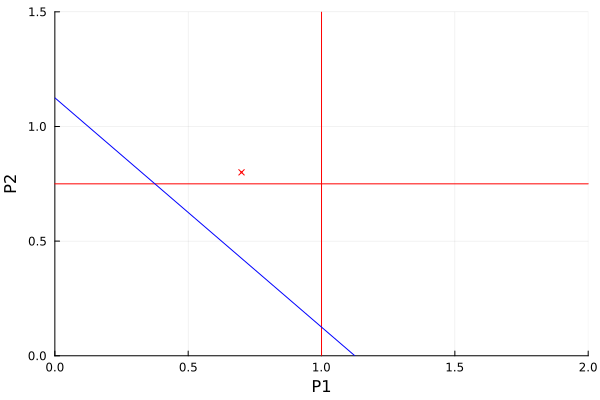

In [8]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
P1, P2 = .7, .8
single_result(build_model_bus_splitting,  P01M, P02M, b01, b02, P1, P2, true)

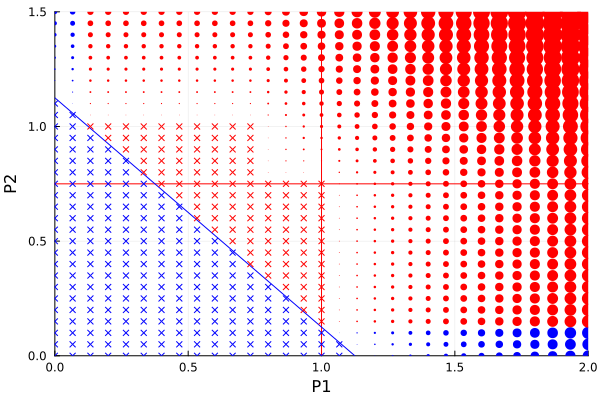

In [9]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
nb, coef = 30, 2
result = build_grid_results(build_model_bus_splitting, P01M, P02M, b01, b02, nb, coef)
plot_grid_results(P01M, P02M, b01, b02, result)